In [135]:
# Import libraries
from bs4 import BeautifulSoup
import os

html_tables = {}

# For every table in the datasets folder...
for table_name in os.listdir('datasets'):
    #this is the path to the file. Don't touch!
    table_path = f'datasets/{table_name}'
    # Open as a python file in read-only mode
    table_file = open(table_path, mode='r')
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file)
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')
    # Add the table to our dictionary
    html_tables[table_name] = html_table

In [137]:
# Read one single day of headlines 
tsla = html_tables['tsla_22sep.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.find_all(id='<tr>')
for i, table_row in enumerate(tsla_tr):
    link_text = table_row.a.get_text()
    data_text = table_row.td .get_text()
    print(f'File number {i+1}:')
    print(link_text)
    print(data_text)
    # The following exits the loop after four rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

In [139]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' with the only element
        # If not, load 'date' with the 1st element and 'time' with the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split("_")[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, x.a.text])

In [141]:
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

In [143]:
import pandas as pd
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame (parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
scored_news.columns = columns
# Join the DataFrames
scored_news = scored_news.join(scores_df)
# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


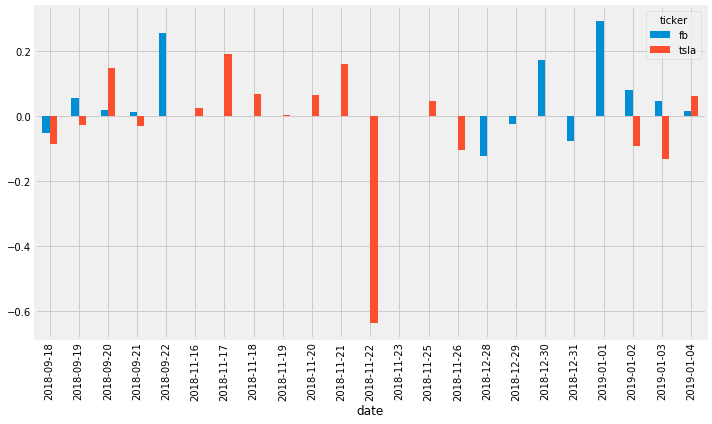

In [145]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()
# Unstack the column ticker
mean_c = mean_c.unstack('ticker')
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs("compound", axis="columns")
# Plot a bar chart with pandas
mean_c.plot.bar(figsize = (10, 6));

In [147]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['headline', 'ticker'])
# Count number of headlines after dropping duplicates (store as integer)
num_news_after = scored_news_clean.headline.count()
# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

In [149]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the fb row
single_day = single_day.xs('fb')
# Select the 3rd of January of 2019
single_day = single_day.loc['2019-01-03']
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# Set the index to time and sort by it
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()

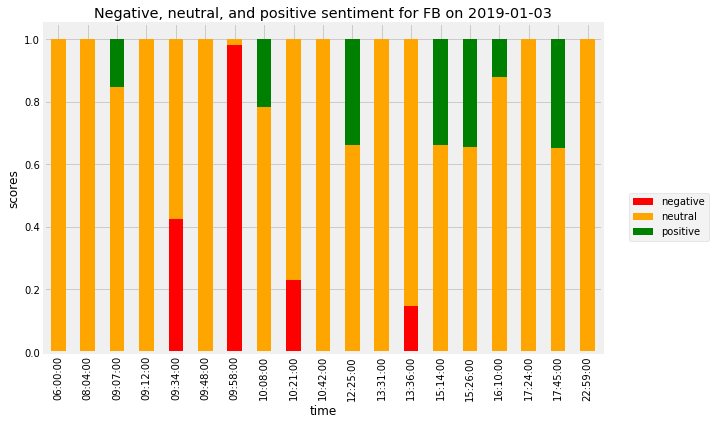

In [151]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2019-01-03"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['compound', 'headline'], 1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");